# **Status and EWMA**

In [4]:
import pandas as pd

# Read the dataset from CSV
df = pd.read_csv("interpolated_filled_output.csv")

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Create a new DataFrame with 'Date' and 'ALT' columns
df_alt = df[['Date', 'ALT']].copy()
df_alt.rename(columns={'ALT': 'Value'}, inplace=True)

# Assign 'NORMAL' to all rows initially
df_alt['Status'] = 'NORMAL'

# Label out-of-range values based on biomarker reference thresholds
df_alt.loc[df_alt['Value'] < 4, 'Status'] = 'LOW'
df_alt.loc[df_alt['Value'] > 50, 'Status'] = 'HIGH'  # Threshold values (e.g., 50 U/L ULN) are manually taken from biomarker reference tables

# Calculate Exponentially Weighted Moving Average (EWMA) and the deviation from it
span = 3
df_alt['EWMA'] = df_alt['Value'].ewm(span=span).mean()
df_alt['Delta_EWMA'] = df_alt['Value'] - df_alt['EWMA']

# Define medical threshold (e.g., 3 × ULN)
threshold_medical = 108  # 3 × 36, value retrieved manually from medical reference for detecting sharp changes

# Define statistical threshold based on IQR
Q1 = df_alt['Delta_EWMA'].quantile(0.25)
Q3 = df_alt['Delta_EWMA'].quantile(0.75)
IQR = Q3 - Q1
threshold_stat = 1.5 * IQR

# Use the more conservative (lower) of the two thresholds
threshold = min(threshold_medical, threshold_stat)

# Mark sharp increases and decreases based on deviation from EWMA
df_alt.loc[df_alt['Delta_EWMA'] > threshold, 'Status'] = 'SHARP_RISE'
df_alt.loc[df_alt['Delta_EWMA'] < -threshold, 'Status'] = 'SHARP_DROP'

# Display the resulting DataFrame
print(df_alt)

         Date      Value      Status       EWMA  Delta_EWMA
0  2024-03-12  70.000000        HIGH  70.000000    0.000000
1  2024-04-11  68.000000        HIGH  68.666667   -0.666667
2  2024-05-11  71.500000        HIGH  70.285714    1.214286
3  2024-06-10  75.000000        HIGH  72.800000    2.200000
4  2024-07-10  64.500000  SHARP_DROP  68.516129   -4.016129
5  2024-08-09  54.000000  SHARP_DROP  61.142857   -7.142857
6  2024-09-08  57.666667        HIGH  59.391076   -1.724409
7  2024-10-08  61.333333        HIGH  60.366013    0.967320
8  2024-11-07  65.000000        HIGH  62.687541    2.312459
9  2024-12-07  62.500000        HIGH  62.593679   -0.093679
10 2025-01-06  60.000000        HIGH  61.296206   -1.296206
11 2025-02-05  72.000000  SHARP_RISE  66.649410    5.350590
12 2025-03-07  78.000000  SHARP_RISE  72.325398    5.674602
13 2025-04-06  71.333333        HIGH  71.829335   -0.496002
14 2025-05-06  64.666667        HIGH  68.247892   -3.581225
15 2025-06-05  58.000000  SHARP_DROP  63

In [5]:
# What happened on which dates?
abnormal_events = df_alt[df_alt['Status'] != 'NORMAL'][['Value', 'Status']]
print(abnormal_events)


        Value      Status
0   70.000000        HIGH
1   68.000000        HIGH
2   71.500000        HIGH
3   75.000000        HIGH
4   64.500000  SHARP_DROP
5   54.000000  SHARP_DROP
6   57.666667        HIGH
7   61.333333        HIGH
8   65.000000        HIGH
9   62.500000        HIGH
10  60.000000        HIGH
11  72.000000  SHARP_RISE
12  78.000000  SHARP_RISE
13  71.333333        HIGH
14  64.666667        HIGH
15  58.000000  SHARP_DROP
16  60.000000        HIGH
17  62.000000        HIGH
18  68.000000        HIGH
19  74.000000  SHARP_RISE
20  70.000000        HIGH
21  66.000000        HIGH
22  67.500000        HIGH
23  69.000000        HIGH
24  70.000000        HIGH
25  71.000000        HIGH


**ADF (Augmented Dickey-Fuller) Test**

To test whether a time series is stationary, the situation where the mean and variance of the time series do not change over time.

In the ADF test:

- If p-value < 0.05: Stationary
- If p-value ≥ 0.05: Non-stationary

ADF Test Statistic: -4.125047420635365
p-value: 0.0008802032719258183
Trend Status (ADF): STATIONARY


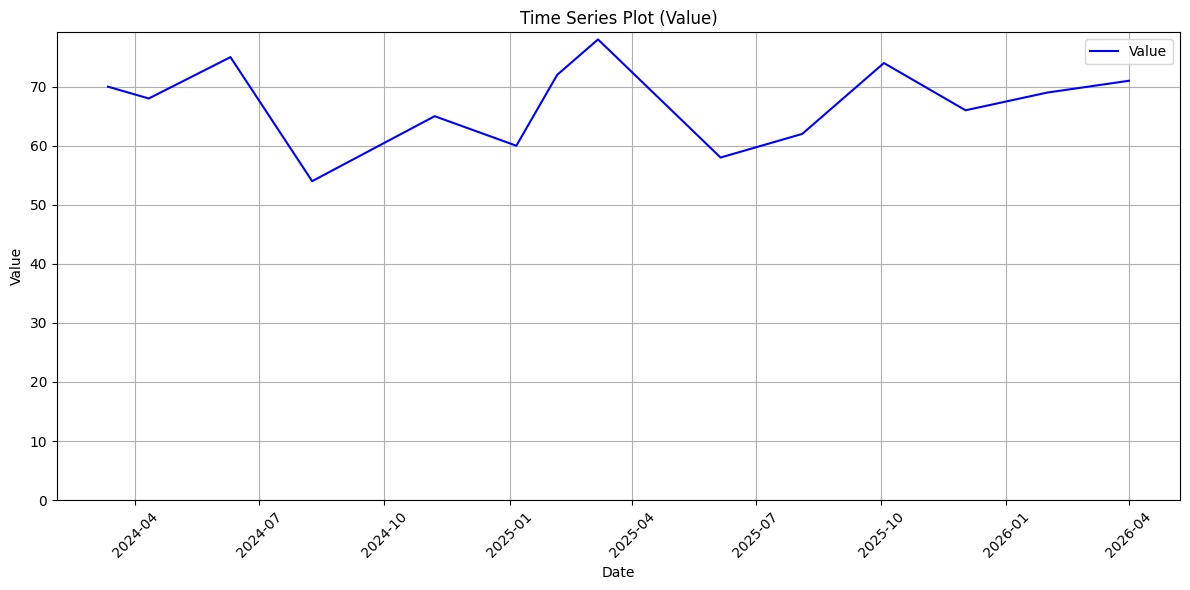

In [6]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Apply Augmented Dickey-Fuller (ADF) test to check stationarity
result = adfuller(df_alt['Value'].dropna())
adf_statistic = result[0]
p_value = result[1]

# Print ADF test results
print(f"ADF Test Statistic: {adf_statistic}")
print(f"p-value: {p_value}")

# Interpret stationarity based on p-value
if p_value < 0.05:
    stationarity = "STATIONARY"
else:
    stationarity = "NON-STATIONARY"

print(f"Trend Status (ADF): {stationarity}")

# Plot time series with 'Date' on the x-axis
plt.figure(figsize=(12, 6))
plt.plot(df_alt['Date'], df_alt['Value'], label='Value', color='blue')

# Start y-axis from zero for better readability
plt.ylim(bottom=0)

# Set plot labels, title, and other formatting options
plt.title('Time Series Plot (Value)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

In [8]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Define window size for moving linear regression
window_size = 3
trends = []

# Convert dates to numerical format (ordinal values)
df_alt['Date_Ordinal'] = df_alt['Date'].map(pd.Timestamp.toordinal)

# Perform moving window linear regression to detect local trends
for i in range(len(df_alt) - window_size + 1):
    x = df_alt['Date_Ordinal'].iloc[i:i + window_size].values.reshape(-1, 1)
    y = df_alt['Value'].iloc[i:i + window_size].values
    model = LinearRegression().fit(x, y)
    slope = model.coef_[0]
    trends.append(slope)

# Add slope values to the DataFrame (NaN for initial rows without enough data)
df_alt['Trend_Slope'] = [None] * (window_size - 1) + trends

# Define a function to interpret slope values into trend categories
def interpret_trend(slope, threshold=0.1):
    if slope is None:
        return "UNKNOWN"
    elif abs(slope) < threshold:
        return "STABLE"
    elif slope >= threshold:
        return "UP"
    elif slope <= -threshold:
        return "DOWN"

# Apply interpretation to each slope value
df_alt['Trend_Label'] = df_alt['Trend_Slope'].apply(lambda s: interpret_trend(s))

# Display the first 25 trend labels
print(df_alt['Trend_Label'].head(15))

0       None
1       None
2     STABLE
3         UP
4       DOWN
5       DOWN
6       DOWN
7         UP
8         UP
9     STABLE
10    STABLE
11        UP
12        UP
13    STABLE
14      DOWN
Name: Trend_Label, dtype: object


## **Trend Analysis**

- From 2024-05-11, the trend was **STABLE** for 1 time steps. Interestingly, the trend remained STABLE, yet the status was HIGH.
- From 2024-06-10, the trend was **UP** for 1 time steps. The upward trend coincided with a HIGH status.
- From 2024-07-10, the trend was **DOWN** for 3 time steps.
- From 2024-10-08, the trend was **UP** for 2 time steps. The upward trend coincided with a HIGH status.
- From 2024-12-07, the trend was **STABLE** for 2 time steps. Interestingly, the trend remained STABLE, yet the status was HIGH.
- From 2025-02-05, the trend was **UP** for 2 time steps. This is notable because a SHARP_RISE was detected during this upward trend.
- From 2025-04-06, the trend was **STABLE** for 1 time steps. Interestingly, the trend remained STABLE, yet the status was HIGH.
- From 2025-05-06, the trend was **DOWN** for 2 time steps.
- From 2025-07-05, the trend was **STABLE** for 2 time steps. Interestingly, the trend remained STABLE, yet the status was HIGH.
- From 2025-09-03, t

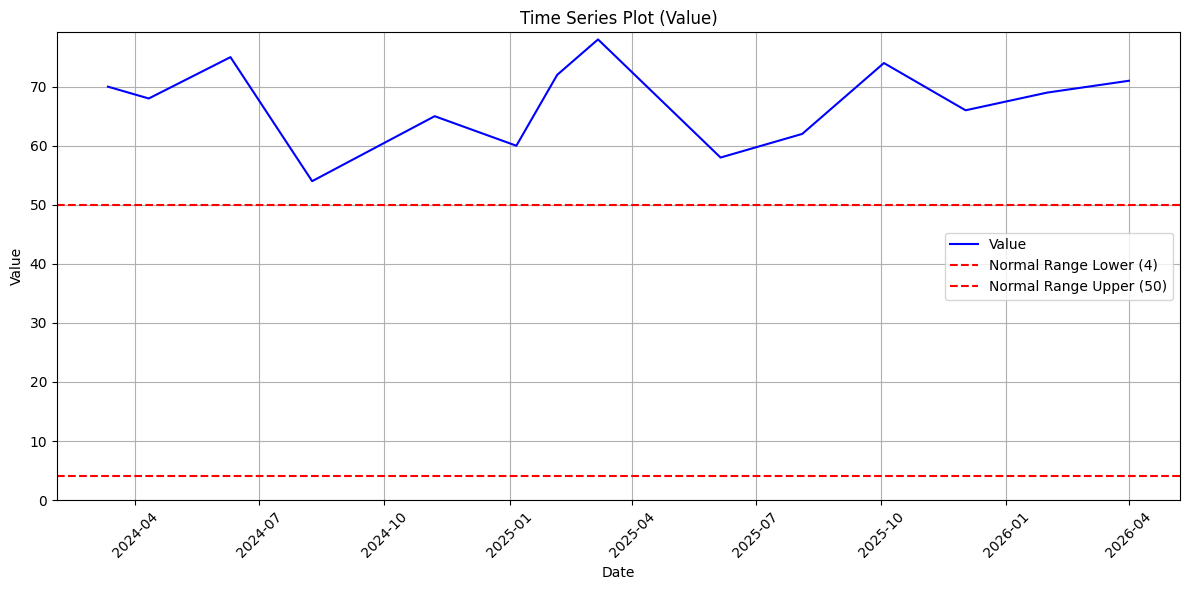

In [9]:
comments = []
current_trend = None
start_index = None

# Iterate through each row to detect trend segments
for i in range(len(df_alt)):
    trend = df_alt.loc[i, 'Trend_Label']
    status = df_alt.loc[i, 'Status']
    date = df_alt.loc[i, 'Date'].date()

    # Check if the trend has changed or if it's the first row
    if trend != current_trend:
        if current_trend is not None and start_index is not None:
            duration = i - start_index
            trend_status_segment = df_alt.iloc[start_index:i]

            segment_date = df_alt.loc[start_index, 'Date'].date()
            segment_statuses = trend_status_segment['Status'].value_counts().to_dict()

            # Generate summary comment for the segment
            comment = f"From {segment_date}, the trend was **{current_trend}** for {duration} time steps."

            # Scenario-based commentary
            if current_trend == "UP" and "SHARP_RISE" in segment_statuses:
                comment += " This is notable because a SHARP_RISE was detected during this upward trend."
            elif current_trend == "DOWN" and "SHARP_DROP" not in segment_statuses:
                comment += " Although the trend was DOWN, no SHARP_DROP was observed."
            elif current_trend == "STABLE" and "HIGH" in segment_statuses:
                comment += " Interestingly, the trend remained STABLE, yet the status was HIGH."
            elif current_trend == "DOWN" and "LOW" in segment_statuses:
                comment += " The trend was DOWN, which aligns with a LOW status."
            elif current_trend == "UP" and "HIGH" in segment_statuses:
                comment += " The upward trend coincided with a HIGH status."

            comments.append(comment)

        # Start a new trend segment
        current_trend = trend
        start_index = i

# Handle the final segment
if current_trend is not None and start_index is not None:
    duration = len(df_alt) - start_index
    trend_status_segment = df_alt.iloc[start_index:]
    segment_date = df_alt.loc[start_index, 'Date'].date()
    segment_statuses = trend_status_segment['Status'].value_counts().to_dict()

    comment = f"From {segment_date}, the trend was **{current_trend}** for {duration} time steps."
    if current_trend == "UP" and "SHARP_RISE" in segment_statuses:
        comment += " This is notable because a SHARP_RISE was detected during this upward trend."
    elif current_trend == "DOWN" and "SHARP_DROP" not in segment_statuses:
        comment += " Although the trend was DOWN, no SHARP_DROP was observed."
    elif current_trend == "STABLE" and "HIGH" in segment_statuses:
        comment += " Interestingly, the trend remained STABLE, yet the status was HIGH."
    elif current_trend == "DOWN" and "LOW" in segment_statuses:
        comment += " The trend was DOWN, which aligns with a LOW status."
    elif current_trend == "UP" and "HIGH" in segment_statuses:
        comment += " The upward trend coincided with a HIGH status."

    comments.append(comment)

# Print generated comments
for c in comments:
    print("- " + c)

# Plot the time series with threshold lines
plt.figure(figsize=(12, 6))
plt.plot(df_alt['Date'], df_alt['Value'], label='Value', color='blue')

# Set the y-axis to start from zero
plt.ylim(bottom=0)

# Add horizontal lines to indicate normal range thresholds
plt.axhline(y=4, color='red', linestyle='--', linewidth=1.5, label='Normal Range Lower (4)')
plt.axhline(y=50, color='red', linestyle='--', linewidth=1.5, label='Normal Range Upper (50)')

# Set plot labels, title, and formatting
plt.title('Time Series Plot (Value)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

In [12]:
# Calculate rolling standard deviation 
rolling_window = 3
df_alt['Rolling_STD'] = df_alt['Value'].rolling(window=rolling_window).std()

# Define fluctuation threshold and label each row 
std_threshold = 5  # Adjust this based on your dataset characteristics
df_alt['Fluctuation'] = df_alt['Rolling_STD'].apply(
    lambda x: 'FLUCTUATING' if x is not None and x > std_threshold else 'STABLE'
)

# Create separate datasets 
recent_period = df_alt[df_alt['Date'] > df_alt['Date'].max() - pd.DateOffset(months=3)]
full_period = df_alt.copy()

# Define a function to summarize trend and fluctuation status 
def summarize_period(name, df_period):
    print(f"\n=== {name.upper()} ANALYSIS ===")

    # Trend counts
    trend_counts = df_period['Trend_Label'].value_counts()
    print("\nTrend Distribution:")
    print(trend_counts)

    # Fluctuation counts
    fluctuation_counts = df_period['Fluctuation'].value_counts()
    print("\nFluctuation Distribution:")
    print(fluctuation_counts)

    # Fluctuation rate (%)
    total = len(df_period)
    fluctuation_rate = fluctuation_counts.get('FLUCTUATING', 0) / total * 100 if total > 0 else 0
    print(f"\nFluctuation Rate: {fluctuation_rate:.2f}%")

    # Comment based on fluctuation rate
    if fluctuation_rate > 50:
        print("Significant fluctuation detected. High variability observed in this period.")
    elif fluctuation_rate > 20:
        print("ℹModerate fluctuation detected. Consider monitoring.")
    else:
        print("Data is mostly stable during this period.")

# Summaries for both timeframes 
summarize_period("Full Data", full_period)
summarize_period("Last 3 Months", recent_period)


=== FULL DATA ANALYSIS ===

Trend Distribution:
Trend_Label
STABLE    11
UP         7
DOWN       6
Name: count, dtype: int64

Fluctuation Distribution:
Fluctuation
STABLE         18
FLUCTUATING     8
Name: count, dtype: int64

Fluctuation Rate: 30.77%
ℹModerate fluctuation detected. Consider monitoring.

=== LAST 3 MONTHS ANALYSIS ===

Trend Distribution:
Trend_Label
STABLE    3
Name: count, dtype: int64

Fluctuation Distribution:
Fluctuation
STABLE    3
Name: count, dtype: int64

Fluctuation Rate: 0.00%
Data is mostly stable during this period.
